In [408]:
import numpy as np
import osr_methods as osr
import line_search_methods as lsm
import matplotlib.pyplot as plt
from timeit import default_timer as timer

### Seleção da função

In [409]:
# 1 - Q1 letra a
# 2 - Q1 letra b
# 3 - Q2 letra a 
func = 2

def f(Xn):
    if (func == 1):
        return Xn[0]**2 - 3*Xn[0]*Xn[1] + 4*(Xn[1]**2) + Xn[0] - Xn[1]
    elif (func == 2):
        a = 10
        b = 1
        return (1 + a - b*Xn[0] - b*Xn[1])**2 + (b + Xn[0] + a*Xn[1] - b*Xn[0]*Xn[1])**2 
    elif (func == 3):
        return 450 *((np.sqrt((30 + Xn[0])**2 + Xn[1]**2) - 30 )**2) + 300 *((np.sqrt((30 - Xn[0])**2 + Xn[1]**2) - 30)**2) - 360*Xn[1]
def grad_f(Xn):
    if (func == 1):
        return np.array([2*Xn[0] - 3*Xn[1] + 1, -3*Xn[0] + 8*Xn[1] - 1])
    elif (func == 2):
        a = 10;
        b = 1;
        return np.array([2*(-a*(b*(Xn[1]**2) + b - Xn[1]) + (b**2)*Xn[0]*(Xn[1]**2 + 1) - 2*b*Xn[0]*Xn[1] + Xn[0]),
                        -2*b*(2*a*Xn[0]*Xn[1] + Xn[0]**2 + 1) + 2*a*(a*Xn[1] + Xn[0]) + 2*(b**2)*(Xn[0]**2 + 1)*Xn[1]])
    elif (func == 3):
        return np.array([(900*(Xn[0] + 30)*(np.sqrt((Xn[0] + 30)**2 + Xn[1]**2) - 30))/np.sqrt((Xn[0] + 30)**2 + Xn[1]**2) - (600*(30 - Xn[0])*(np.sqrt((Xn[0] - 30)**2 + Xn[1]**2) - 30))/np.sqrt((Xn[0] - 30)**2 + Xn[1]**2),
                        60*(Xn[1]*(-450/np.sqrt(Xn[0]**2 + 60*Xn[0] + Xn[1]**2 + 900) - 300/np.sqrt(Xn[0]**2 - 60*Xn[0] + Xn[1]**2 + 900) + 25) - 6)])
def hessian_f(Xn):
    if (func == 1):
        return np.array([[2, -3],
                       [-3, 8]], dtype=float)
    elif (func == 2):
        a = 10;
        b = 1;
        hessian = np.zeros((2,2))
        hessian[0, 0] = 2*(b**2) + 2*((1 - b*Xn[1])**2)
        hessian[0, 1] = -2*b*(a*Xn[1] + b*(-Xn[0]*Xn[1]) + b + Xn[0]) + 2*(1-b*Xn[1])*(a - b*Xn[0]) + 2*(b**2)
        hessian[1, 0] = -2*b*(a*Xn[1] + b*(-Xn[0]*Xn[1]) + b + Xn[0]) + 2*(1-b*Xn[1])*(a-b*Xn[0]) + 2*(b**2)
        hessian[1, 1] = 2*((a-b*Xn[0])**2) + 2*(b**2)
        return hessian

### Seleção do ponto inicial

In [410]:
if (func == 1):
    P0 = np.array([2, 2])
    #P0 = [-1, -3]
elif (func == 2):
    #P0 = np.array([10, 2])
    P0 = np.array([-2, -3])
elif (func == 3):
    P0 = np.array([0.01, -0.1])


### Controle Numérico

In [411]:
maxiter = 200
tol_conv = 0.00001
tol_search = 0.00000001
line_step = 0.0001

### Seleção do Método de OSR

In [412]:
# 1 - Univariante
# 2 - Powell
# 3 - Steepest Descent
# 4 - Newton Raphson
# 5 - Fletcher Reeves
# 6 - BFGS

metodo = 1

if (metodo == 1):
    nome_met = 'Univariante'
elif (metodo == 2):
    nome_met = 'Powell'
elif (metodo == 3):
    nome_met = 'Steepest Descent'
elif (metodo == 4):
    nome_met = 'Newton Raphson'
elif (metodo == 5):
    nome_met = 'Fletcher-Reeves'
elif (metodo == 6):
    nome_met = 'BFGS'

### Inicializações

In [413]:
passos = 0
ciclos = 0
dimens = P0.size
P1 = P0.copy()
direcoes = np.eye(dimens, dtype=float)
Pmin = P0.copy()
listPmin = []
listPmin.append(Pmin)
grad = grad_f(Pmin)
grad_last = grad.copy()
norm_grad = np.linalg.norm(grad)
dir = np.zeros((1, dimens))

if(metodo == 6):
    S_last = np.eye(dimens)
    grad_last = grad.copy()
    P_last = P0.copy()

### Cálculo do Ponto Mínimo

In [414]:
start = timer()
while (norm_grad > tol_conv):
    if (passos == maxiter):
        print('Nao convergiu')
        break
    passos = passos + 1
    if (metodo == 1):
        dir = osr.univariante(passos, dimens)
    elif (metodo == 2):
        dir, direcoes, P1, ciclos = osr.powell(Pmin, P1, direcoes,passos, ciclos, dimens)
    elif (metodo == 3):
        dir = osr.steepestDescent(grad)
    elif (metodo == 4):
        dir = osr.newtonRaphson(Pmin, grad, hessian_f)
    elif (metodo == 5):
        dir, grad_last = osr.fletcherReeves(dir, grad, grad_last, passos)
    elif (metodo == 6):
        dir, P_last, grad_last, S_last = osr.bfgs(Pmin, P_last, grad, grad_last, S_last, passos, dimens)
        
    intervalo = lsm.passo_cte(dir, Pmin, f, line_step)
    alpha = lsm.secao_aurea(intervalo, dir, Pmin, f, tol_search)
    Pmin = Pmin + alpha*dir
    listPmin.append(Pmin)
    grad = grad_f(Pmin)
    norm_grad = np.linalg.norm(grad)
    print(f'Ciclo{ciclos}, Passo{passos}, Pmin={Pmin}, d={dir}')

end = timer()

tempoExec = end - start
print(f'tempo= {tempoExec}')


Ciclo0, Passo1, Pmin=[ 4.34688178 -0.47250918], d=[3.20016224 1.27438653]
Ciclo0, Passo2, Pmin=[ 6.51327995 -1.10973336], d=[ 2.6268924  -0.77267392]
Ciclo0, Passo3, Pmin=[ 6.64823562 -1.76160102], d=[ 0.12081813 -0.58357999]
Ciclo0, Passo4, Pmin=[ 6.99503593 -1.98436363], d=[ 0.41087782 -0.26392195]
Ciclo0, Passo5, Pmin=[ 6.99986391 -1.99991153], d=[ 0.00480396 -0.01547055]
Ciclo0, Passo6, Pmin=[ 6.99999988 -1.99999992], d=[ 1.36103229e-04 -8.84771404e-05]
tempo= 0.3830445169987797


### Plot

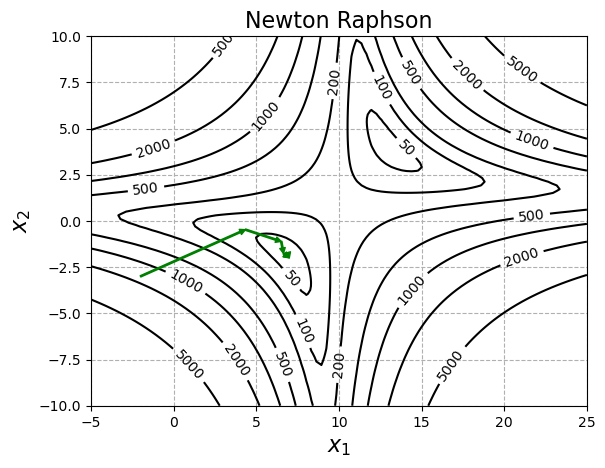

In [415]:
if (func == 1):
    x1 = np.linspace(-2, 3, 100)
    x2 = np.linspace(-1, 2.5, 100)
    X1, X2 = np.meshgrid(x1, x2)
    X3 = f([X1, X2])
    niveis = plt.contour(X1, X2, X3, [-0.2, 0, 1, 3, 6, 10, 25], colors='black')
elif (func == 2):
    x1 = np.linspace(-5, 25, 100)
    x2 = np.linspace(-10, 10, 100)
    X1, X2 = np.meshgrid(x1, x2)
    X3 = f([X1, X2])
    niveis = plt.contour(X1, X2, X3,[50, 100,200,500, 1000, 2000, 5000], colors='black')
plt.clabel(niveis, inline=1, fontsize=10)

for i in np.arange(len(listPmin)-1):
    plt.annotate('', xy=listPmin[i+1], xytext=listPmin[i],
                arrowprops=dict(width=1, color='green', headwidth=4, headlength=4, shrink=0.0), fontsize='10')
#    #plt.plot(pontos[i][0], pontos[i][1], marker="o", markersize=7, markeredgecolor="green", markerfacecolor="green")
#    #plt.plot(pontos[i+1][0], pontos[i+1][1], marker="o", markersize=1, markeredgecolor="green", markerfacecolor="green")
plt.xlabel('$x_1$', fontsize='16')
plt.ylabel('$x_2$', fontsize='16')
plt.grid(linestyle='--')
plt.title(nome_met, fontsize='16')
##plt.savefig("A_solution.pdf", format="pdf")
plt.show()